# Compare migration event times to shuffled dates

In a different notebook `estimate-migration-event-timing`, I wrote some code to pull out when migration events were occurring on the tree. From those results, it looked like there was an uptick in human infections in the winter months. However, the distributions were wide, and it was hard to tell whether this differed from the expectation of equal cross-species transmission over time. So to get a null distribution, I reran the beast runs, but with shuffled months. For this, I took each sequence and re-assigned its month to be a random number from 1-12. I did this 10 times, reran the beast runs, and now want to compare the distribution of migration event times across those 10 random runs compared to the original. This notebook performs and plots that comparison. 

To run this does require running the `estimate-migration-event-timing` on the original and shuffled dates data up through the point where 2 output files have been generated: `combined-date.muts.trees.migrations-date.tsv` and `combined.trees.prop-migrations-per-month-date.tsv`. 

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '../baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

from io import StringIO
import time

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [7]:
data = {"migs": "beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-muts-trees-2021-08-23.muts.trees.migrations-2021-08-23.tsv",
        "migs_per_month":"beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-muts-trees-2021-08-23.muts.trees.prop-migrations-per-month-2021-08-23.tsv",
        "trees":"beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-muts-trees-2021-08-23.muts.trees"}

controls = {"migs":"beast-runs/2021-12-21-mascot-3deme-skyline-shuffled-months/combined-2022-03-28.muts.trees.migrations-2022-03-28.tsv", 
            "migs_per_month":"beast-runs/2021-12-21-mascot-3deme-skyline-shuffled-months/combined-2022-03-28.muts.trees.prop-migrations-per-month-2022-03-28.tsv", 
            "trees": "beast-runs/2021-12-21-mascot-3deme-skyline-shuffled-months/combined-2022-03-28.muts.trees"}

In [8]:
migs = pd.read_csv(data["migs"], sep="\t")
control_migs = pd.read_csv(controls["migs"], sep="\t")

migs_per_month = pd.read_csv(data["migs_per_month"], sep="\t")
control_migs_per_month = pd.read_csv(controls["migs_per_month"], sep="\t")

In [9]:
# make a summary table with the mean per month per direction, with confidence intervals 

def output_hpd_intervals(input_df):
    import pymc3
    summary_table = pd.DataFrame()

    for migration_direction in set(input_df['migration_direction'].tolist()):
        for month in set(input_df['month'].tolist()):
            local_df = input_df[(input_df["migration_direction"]==migration_direction) & (input_df["month"]==month)]

            mean = local_df['proportion_transitions_in_time_interval'].mean()
            hpd = pymc3.stats.hpd(local_df['proportion_transitions_in_time_interval'], 0.95)
            lower_hpd = hpd[0]
            upper_hpd = hpd[1]
            
            percentile = np.percentile(local_df['proportion_transitions_in_time_interval'],95)

            new_df = pd.DataFrame.from_dict({"migration_direction":migration_direction, "month":month,
                                            "mean":mean, "lower_hpd":[lower_hpd], "upper_hpd": [upper_hpd],
                                            "percentile":percentile})

            summary_table = summary_table.append(new_df)

    return(summary_table)

In [10]:
controls_summary_df = output_hpd_intervals(control_migs_per_month)
controls_summary_df['data'] = "shuffled_dates"
controls_summary_df

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


,migration_direction,month,mean,lower_hpd,upper_hpd,percentile,data
0,wild-to-domestic,1,0.086430,0.044304,0.128834,0.122497,shuffled_dates
0,wild-to-domestic,2,0.078313,0.038217,0.119403,0.114650,shuffled_dates
0,wild-to-domestic,3,0.084792,0.043956,0.129032,0.123476,shuffled_dates
0,wild-to-domestic,4,0.081198,0.039474,0.124294,0.119497,shuffled_dates
0,wild-to-domestic,5,0.082874,0.037634,0.123153,0.120241,shuffled_dates
0,wild-to-domestic,6,0.080104,0.037975,0.119048,0.115385,shuffled_dates
0,wild-to-domestic,7,0.083729,0.040698,0.123457,0.120209,shuffled_dates
0,wild-to-domestic,8,0.083736,0.042945,0.125000,0.121212,shuffled_dates
0,wild-to-domestic,9,0.082601,0.042553,0.127273,0.120617,shuffled_dates
0,wild-to-domestic,10,0.086644,0.041667,0.127551,0.123596,shuffled_dates


In [11]:
data_summary_df = output_hpd_intervals(migs_per_month)
data_summary_df['data'] = "data"
data_summary_df

,migration_direction,month,mean,lower_hpd,upper_hpd,percentile,data
0,wild-to-domestic,1,0.092790,0.047945,0.141026,0.134328,data
0,wild-to-domestic,2,0.079292,0.037037,0.122642,0.116279,data
0,wild-to-domestic,3,0.081132,0.037037,0.126984,0.121387,data
0,wild-to-domestic,4,0.074819,0.034483,0.120690,0.113636,data
0,wild-to-domestic,5,0.074490,0.032468,0.119048,0.112299,data
0,wild-to-domestic,6,0.072345,0.029197,0.113043,0.109589,data
0,wild-to-domestic,7,0.080953,0.037594,0.125000,0.119266,data
0,wild-to-domestic,8,0.080822,0.033333,0.126050,0.121212,data
0,wild-to-domestic,9,0.080447,0.037267,0.125000,0.119403,data
0,wild-to-domestic,10,0.092145,0.047619,0.141414,0.133803,data


In [12]:
combined_df = controls_summary_df.append(data_summary_df)
combined_df.head()

,migration_direction,month,mean,lower_hpd,upper_hpd,percentile,data
0,wild-to-domestic,1,0.086430,0.044304,0.128834,0.122497,shuffled_dates
0,wild-to-domestic,2,0.078313,0.038217,0.119403,0.114650,shuffled_dates
0,wild-to-domestic,3,0.084792,0.043956,0.129032,0.123476,shuffled_dates
0,wild-to-domestic,4,0.081198,0.039474,0.124294,0.119497,shuffled_dates
0,wild-to-domestic,5,0.082874,0.037634,0.123153,0.120241,shuffled_dates


In [13]:
domestic_human_df = combined_df[combined_df['migration_direction']=='domestic-to-human']
domestic_human_df

,migration_direction,month,mean,lower_hpd,upper_hpd,percentile,data
0,domestic-to-human,1,0.085169,0.036036,0.139130,0.130841,shuffled_dates
0,domestic-to-human,2,0.079631,0.035714,0.135417,0.125000,shuffled_dates
0,domestic-to-human,3,0.090072,0.035398,0.144330,0.138793,shuffled_dates
0,domestic-to-human,4,0.087416,0.035088,0.141509,0.133720,shuffled_dates
0,domestic-to-human,5,0.084922,0.035714,0.141509,0.133333,shuffled_dates
0,domestic-to-human,6,0.077246,0.026786,0.128440,0.122574,shuffled_dates
0,domestic-to-human,7,0.080772,0.035398,0.137615,0.128440,shuffled_dates
0,domestic-to-human,8,0.080501,0.027273,0.127451,0.125000,shuffled_dates
0,domestic-to-human,9,0.078876,0.027523,0.126214,0.123810,shuffled_dates
0,domestic-to-human,10,0.087151,0.035398,0.137615,0.132712,shuffled_dates


In [14]:
df1 = migs_per_month
df2 = control_migs_per_month
df1['data'] = "data"
df2['data'] = 'shuffled_dates'

df3 = df1.append(df2)
df3.head()

,Unnamed: 0,migration_direction,month,tree_number,total_transitions,transitions_in_time_interval,proportion_transitions_in_time_interval,data
0,0,wild-to-human,1,1,1,0,0.0,data
1,0,wild-to-human,2,1,1,0,0.0,data
2,0,wild-to-human,3,1,1,1,1.0,data
3,0,wild-to-human,4,1,1,0,0.0,data
4,0,wild-to-human,5,1,1,0,0.0,data


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


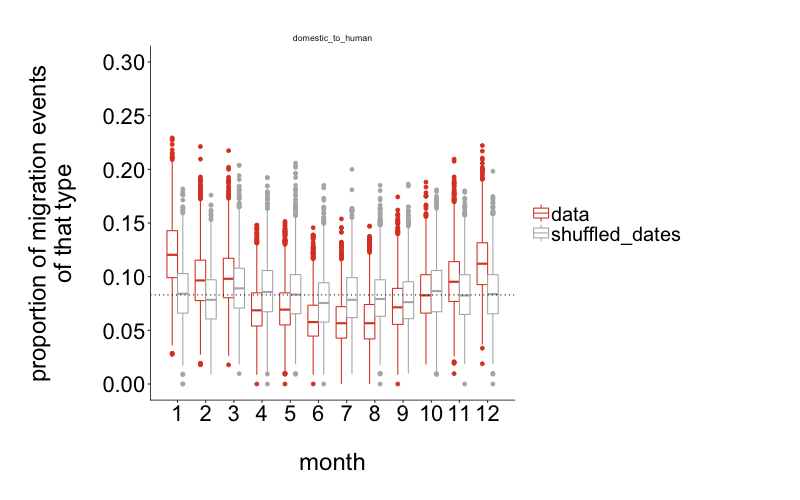

In [15]:
%%R -w 800 -h 500 -u px -i df3,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

mig <- df3

output_filename = paste("mig-times-domestic-to-human-",current_date,".pdf", sep="")

mig$migration_direction = gsub("-","_",mig$migration_direction)
mig$month = as.numeric(mig$month)

# optionally, remove wild to human
mig <- mig[(mig$migration_direction=="domestic_to_human"),]

p <- ggplot(data=mig, aes(x=month, y=proportion_transitions_in_time_interval, color=data,group=interaction(month,data))) + 
    #geom_point(size=1, alpha=0.6)+
    geom_boxplot(position="dodge")+
    geom_hline(yintercept=0.083, linetype=3)+
    facet_wrap(~migration_direction, ncol=1)+
    #geom_line(stat="count")+
    labs(x="\nmonth", y="proportion of migration events\nof that type\n")+
    scale_color_manual(values=c(data=human_color,shuffled_dates="grey70"))+
    scale_y_continuous(breaks=seq(0,0.3,0.05), limits=c(0,0.3))+
    scale_x_continuous(breaks=seq(1,12,1))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 16, height = 8, device = "pdf", path = "figures", dpi = 300)
p

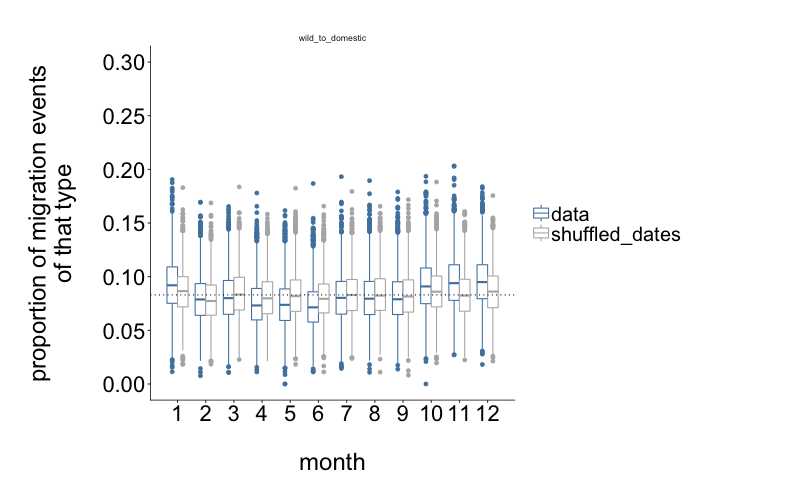

In [16]:
%%R -w 800 -h 500 -u px -i df3,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

mig <- df3

output_filename = paste("mig-times-wild-to-domestic-",current_date,".pdf", sep="")

mig$migration_direction = gsub("-","_",mig$migration_direction)
mig$month = as.numeric(mig$month)

# optionally, remove wild to human
mig <- mig[(mig$migration_direction=="wild_to_domestic"),]

p <- ggplot(data=mig, aes(x=month, y=proportion_transitions_in_time_interval, color=data,group=interaction(month,data))) + 
    #geom_point(size=1, alpha=0.6)+
    geom_boxplot(position="dodge")+
    geom_hline(yintercept=0.083, linetype=3)+
    facet_wrap(~migration_direction, ncol=1)+
    #geom_line(stat="count")+
    labs(x="\nmonth", y="proportion of migration events\nof that type\n")+
    scale_color_manual(values=c(data=domestic_color,shuffled_dates="grey70"))+
    scale_y_continuous(breaks=seq(0,0.3,0.05), limits=c(0,0.3))+
    scale_x_continuous(breaks=seq(1,12,1))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 16, height = 8, device = "pdf", path = "figures", dpi = 300)
p

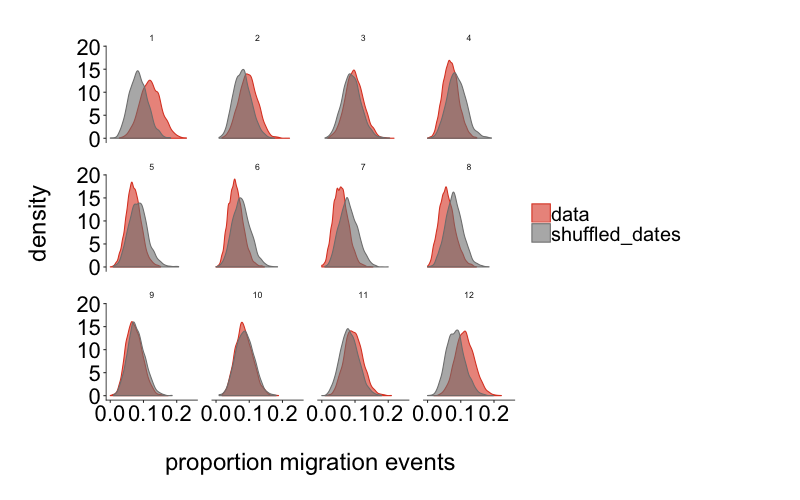

In [17]:
%%R -w 800 -h 500 -u px -i df3,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

mig <- df3

output_filename = paste("mig-times-density-domestic-to-human-",current_date,".pdf", sep="")

mig$migration_direction = gsub("-","_",mig$migration_direction)
mig$month = as.numeric(mig$month)

# optionally, remove wild to human
mig <- mig[(mig$migration_direction=="domestic_to_human"),]

p <- ggplot(data=mig, aes(x=proportion_transitions_in_time_interval, color=data,group=data)) + 
    #geom_point(size=1, alpha=0.6)+
    geom_density(data=mig, aes(x=proportion_transitions_in_time_interval, color=data, fill=data, group=data), trim=TRUE, alpha=0.6, linetype="solid",size=0.5)+
    #geom_hline(yintercept=0.083, linetype=3)+
    facet_wrap(~month, ncol=4)+
    #geom_line(stat="count")+
    labs(x="\nproportion migration events", y="density\n")+
    scale_color_manual(values=c(data=human_color,shuffled_dates="grey50"))+
    scale_fill_manual(values=c(data=human_color,shuffled_dates="grey50"))+
    #scale_y_continuous(breaks=seq(0,0.3,0.05), limits=c(0,0.3))+
    scale_x_continuous(breaks=seq(0,0.25,0.1), limits=c(0,0.25))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 20, height = 12, device = "pdf", path = "figures", dpi = 300)
p

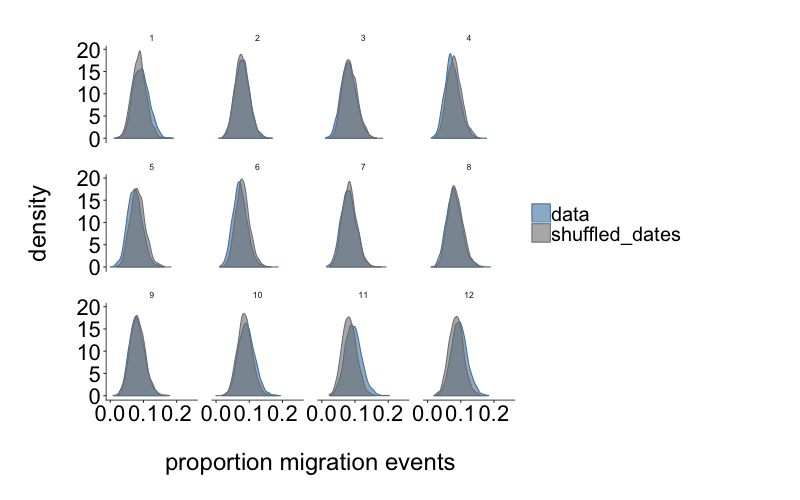

In [18]:
%%R -w 800 -h 500 -u px -i df3,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

mig <- df3

output_filename = paste("mig-times-month-density-wild-to-domestic-",current_date,".pdf", sep="")

mig$migration_direction = gsub("-","_",mig$migration_direction)
mig$month = as.numeric(mig$month)

# optionally, remove wild to human
mig <- mig[(mig$migration_direction=="wild_to_domestic"),]

p <- ggplot(data=mig, aes(x=proportion_transitions_in_time_interval, color=data,group=data)) + 
    #geom_point(size=1, alpha=0.6)+
    geom_density(data=mig, aes(x=proportion_transitions_in_time_interval, color=data, fill=data, group=data), trim=TRUE, alpha=0.6, linetype="solid",size=0.5)+
    #geom_hline(yintercept=0.083, linetype=3)+
    facet_wrap(~month, ncol=4)+
    #geom_line(stat="count")+
    labs(x="\nproportion migration events", y="density\n")+
    scale_color_manual(values=c(data=domestic_color,shuffled_dates="grey50"))+
    scale_fill_manual(values=c(data=domestic_color,shuffled_dates="grey50"))+
    #scale_y_continuous(breaks=seq(0,0.3,0.05), limits=c(0,0.3))+
    scale_x_continuous(breaks=seq(0,0.25,0.1), limits=c(0,0.25))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 20, height = 12, device = "pdf", path = "figures", dpi = 300)
p

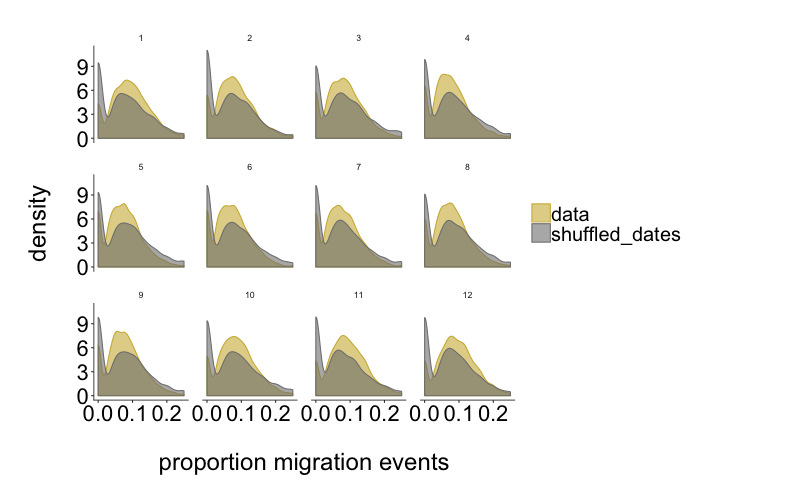

In [22]:
%%R -w 800 -h 500 -u px -i df3,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

mig <- df3

output_filename = paste("mig-times-month-density-domestic-to-wild-",current_date,".pdf", sep="")

mig$migration_direction = gsub("-","_",mig$migration_direction)
mig$month = as.numeric(mig$month)

# optionally, remove wild to human
mig <- mig[(mig$migration_direction=="domestic_to_wild"),]

p <- ggplot(data=mig, aes(x=proportion_transitions_in_time_interval, color=data,group=data)) + 
    #geom_point(size=1, alpha=0.6)+
    geom_density(data=mig, aes(x=proportion_transitions_in_time_interval, color=data, fill=data, group=data), trim=TRUE, alpha=0.6, linetype="solid",size=0.5)+
    #geom_hline(yintercept=0.083, linetype=3)+
    facet_wrap(~month, ncol=4)+
    #geom_line(stat="count")+
    labs(x="\nproportion migration events", y="density\n")+
    scale_color_manual(values=c(data=wild_color,shuffled_dates="grey50"))+
    scale_fill_manual(values=c(data=wild_color,shuffled_dates="grey50"))+
    #scale_y_continuous(breaks=seq(0,0.3,0.05), limits=c(0,0.3))+
    scale_x_continuous(breaks=seq(0,0.25,0.1), limits=c(0,0.25))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 20, height = 12, device = "pdf", path = "figures", dpi = 300)
p

### Try plotting all together

In [19]:
df3.head()

,Unnamed: 0,migration_direction,month,tree_number,total_transitions,transitions_in_time_interval,proportion_transitions_in_time_interval,data
0,0,wild-to-human,1,1,1,0,0.0,data
1,0,wild-to-human,2,1,1,0,0.0,data
2,0,wild-to-human,3,1,1,1,1.0,data
3,0,wild-to-human,4,1,1,0,0.0,data
4,0,wild-to-human,5,1,1,0,0.0,data


In [21]:
df3['colorby'] = df3['migration_direction'].str.replace("-","_") + "_" + df3['data']
df3.head()

,Unnamed: 0,migration_direction,month,tree_number,total_transitions,transitions_in_time_interval,proportion_transitions_in_time_interval,data,colorby
0,0,wild-to-human,1,1,1,0,0.0,data,wild_to_human_data
1,0,wild-to-human,2,1,1,0,0.0,data,wild_to_human_data
2,0,wild-to-human,3,1,1,1,1.0,data,wild_to_human_data
3,0,wild-to-human,4,1,1,0,0.0,data,wild_to_human_data
4,0,wild-to-human,5,1,1,0,0.0,data,wild_to_human_data


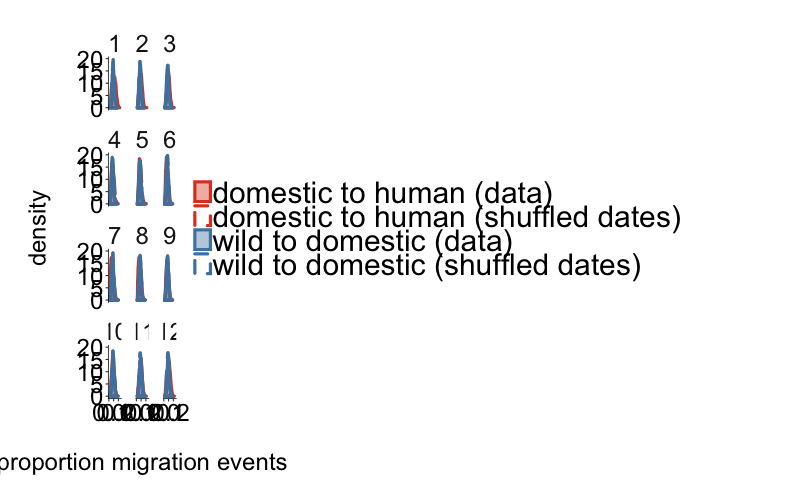

In [37]:
%%R -w 800 -h 500 -u px -i df3,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

mig <- df3

output_filename = paste("mig-times-month-density-all-",current_date,".pdf", sep="")

mig$migration_direction = gsub("-","_",mig$migration_direction)
mig$month = as.numeric(mig$month)

# remove domestic to wild and wild to human
mig <- mig[(mig$migration_direction!="domestic_to_wild"),]
mig <- mig[(mig$migration_direction!="wild_to_human"),]


p <- ggplot(data=mig, aes(x=proportion_transitions_in_time_interval, color=colorby,group=colorby, linetype=colorby)) + 
    #geom_point(size=1, alpha=0.6)+
    geom_density(data=mig, aes(x=proportion_transitions_in_time_interval, color=colorby, fill=colorby, group=colorby, linetype=colorby), trim=TRUE, alpha=0.4, size=1.5)+
    #geom_hline(yintercept=0.083, linetype=3)+
    facet_wrap(~month, ncol=3)+
    #geom_line(stat="count")+
    labs(x="\nproportion migration events", y="density\n")+
    scale_color_manual(values=c(wild_to_domestic_data=domestic_color,wild_to_domestic_shuffled_dates=domestic_color,domestic_to_human_data=human_color, domestic_to_human_shuffled_dates=human_color), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
    scale_fill_manual(values=c(wild_to_domestic_data=domestic_color,wild_to_domestic_shuffled_dates=NA,domestic_to_human_data=human_color, domestic_to_human_shuffled_dates=NA), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
    scale_linetype_manual(values=c(wild_to_domestic_data="solid",wild_to_domestic_shuffled_dates="dashed",domestic_to_human_data="solid", domestic_to_human_shuffled_dates="dashed"), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
    #scale_y_continuous(breaks=seq(0,0.3,0.05), limits=c(0,0.3))+
    scale_x_continuous(breaks=seq(0,0.25,0.1), limits=c(0,0.25))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+  
    theme(strip.text.x=element_text(size=24))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(size=24, colour="black", hjust=0.5))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.text=element_text(size=30))+
    theme(legend.title=element_blank())

    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 30, height = 16, device = "pdf", path = "figures", dpi = 300)
p

## Interpretation

My interpretation here is that on average, the distribution of transmission events from domestic birds to humans is more shifted from expectation than the distribution of transmission events from domestic birds to wild birds. However, the distributions are so overlapping that it is almost certainly not statistically significant. 